# SEGMENTATION MODEL

### Prepare Library, Parameters, and Dependencies

In [1]:
# Install pix2pix Library
%pip install -q git+https://github.com/tensorflow/examples.git --quiet

  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

%matplotlib inline

In [3]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


In [5]:
# Set Parameters
SEG_DATASET = "dataset/iris_needle_seg_dataset"

BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2
SHUFFLE_BUFFER_SIZE_SEG = 10000

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

### Load Dataset

In [6]:
# USE THIS IF YOU USE LOCAL MACHINE

# # Load OG Image Path
# image_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_original/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              image_path.append(os.path.join(root, file))
# print(len(image_path))
# print(image_path[1])

# # Load Mask Image Path
# mask_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_mask/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              mask_path.append(os.path.join(root, file))
# print(len(mask_path))
# print(mask_path[1])

In [7]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask',file)
        image_path.append(path_og)
        mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(image_path))
print(image_path[1])

print(len(mask_path))
print(mask_path[1])

1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg
1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg


### Decode Dataset Into Array

In [8]:
# Decode Mask Image
masks = []
for path in tqdm(mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    masks.append(mask_array)

# Decode OG Image
images = []
for path in tqdm(image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    images.append(img_array)

100%|██████████| 1476/1476 [00:04<00:00, 314.72it/s]


### Visualize Dataset

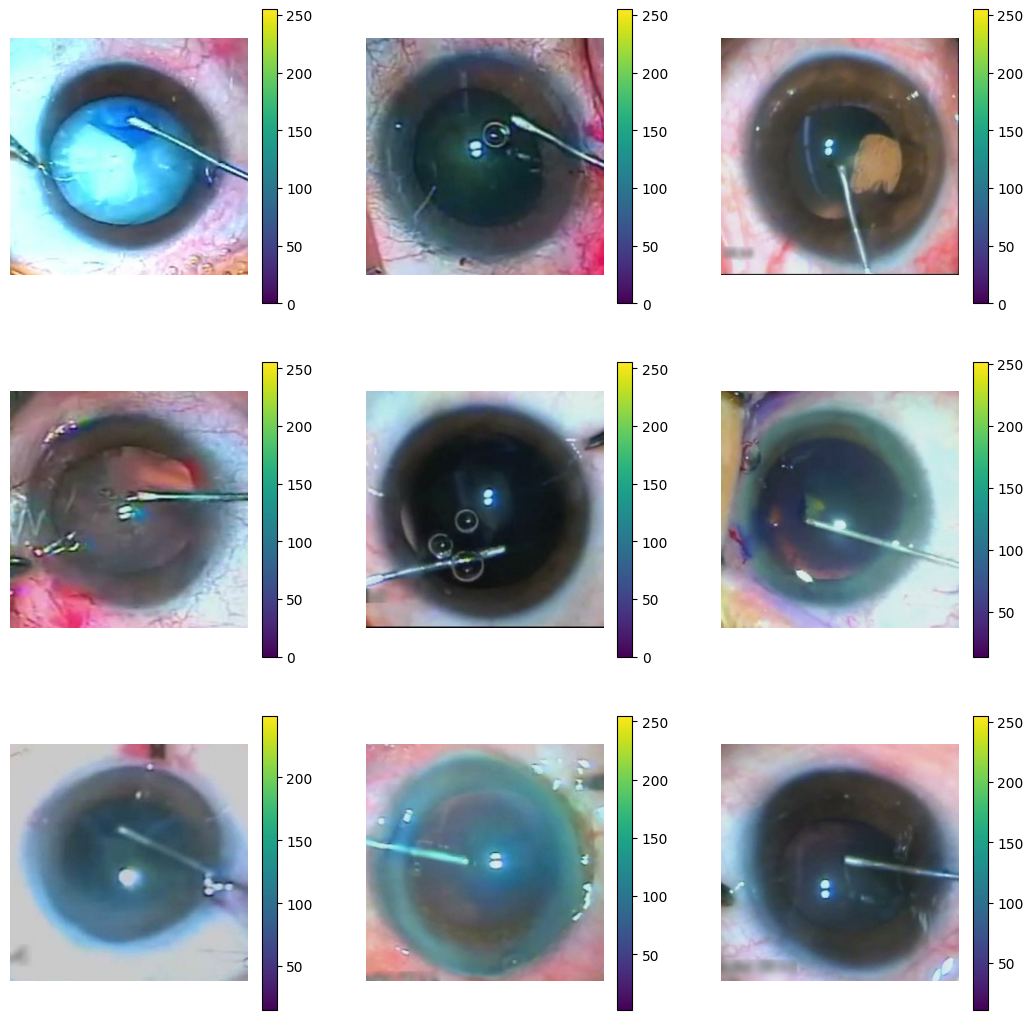

In [9]:
# Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

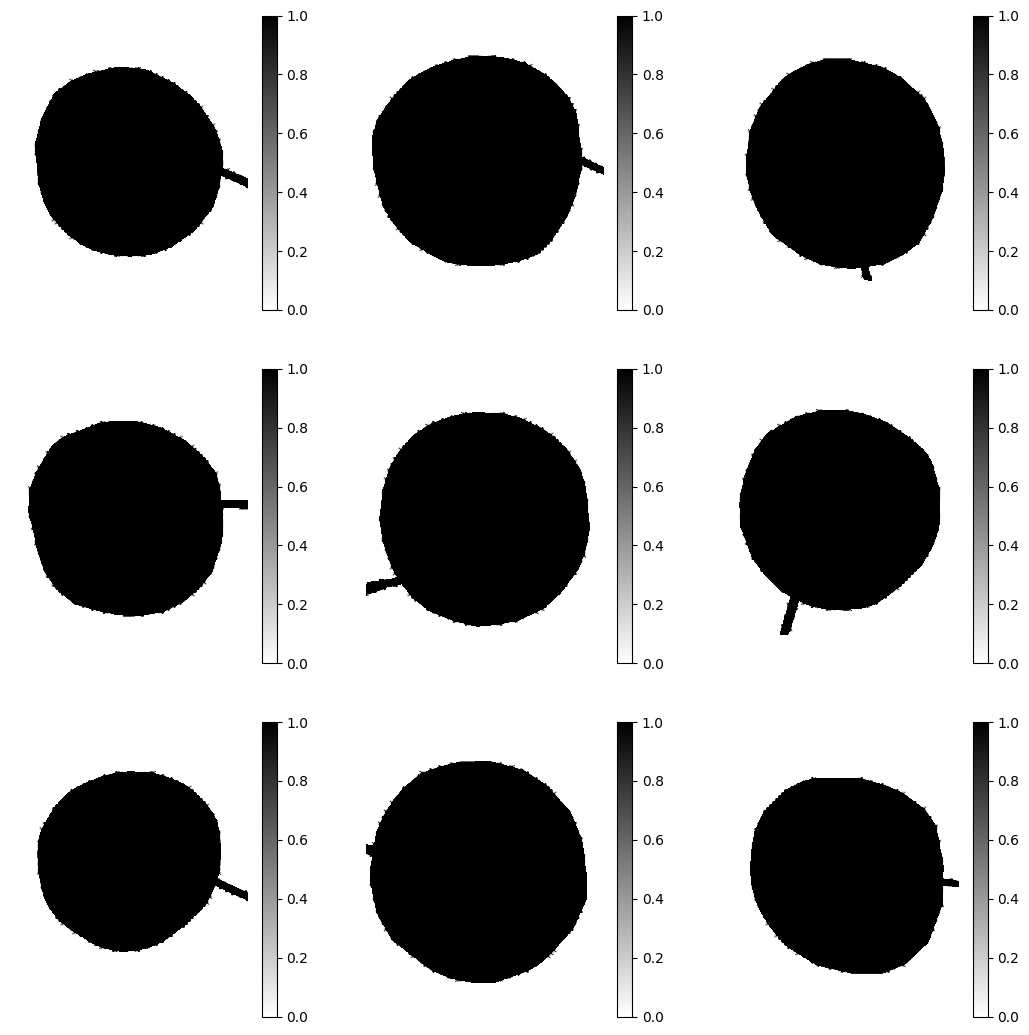

In [10]:
# Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

### Resize Dataset

In [11]:
# Resize Function for Dataset OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Resize Function for Dataset Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

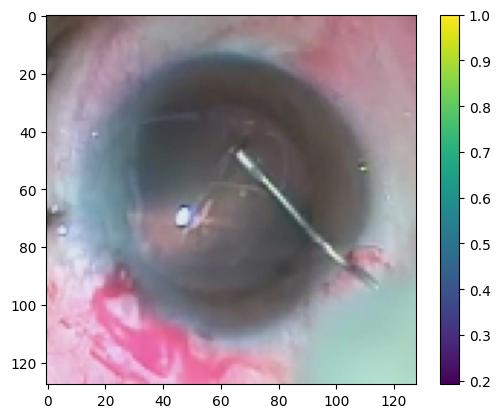

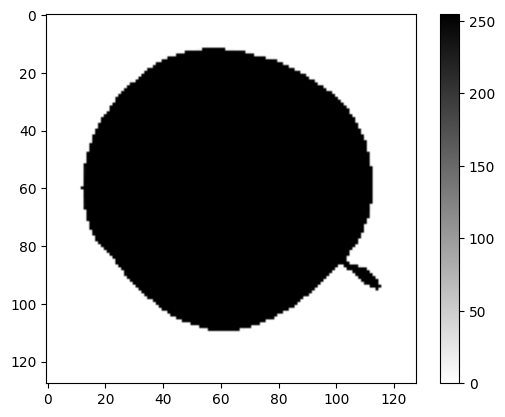

In [12]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

### Split Dataset & Change Dataset Into TensorFlow Dataset

In [13]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=42)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

# Verify the Shapes and Data Types
X_train.element_spec, y_train.element_spec, X_val.element_spec, y_val.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

### Dataset Augmentation

In [14]:
# Data Augmentation Function
def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [15]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

# Perform Data Augmentation
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

### Dataset Pipelining

In [17]:
train = train.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

### Callbacks

In [18]:
stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

### Model Architecture #1 (U-Net w/ Transfer Learning & Generative Model pix2pix)

In [19]:
# Load DenseNet121 as Base Model
base = keras.applications.DenseNet121(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False, weights='imagenet')

In [20]:
# Define Skip Layer Names from Base Model
skip_layer_names = [
    'conv1/relu', # size 64*64
    'pool2_relu',  # size 32*32
    'pool3_relu',  # size 16*16
    'pool4_relu',  # size 8*8
    'relu'        # size 4*4
]

In [21]:
# Retrieve Skip Layer Outputs
skip_outputs = [base.get_layer(name).output for name in skip_layer_names]

# Create the Downstack from the Base Model
downstack = keras.Model(inputs=base.input, outputs=skip_outputs)

# Freeze the Downstack Layers
downstack.trainable = True

In [22]:
# Define the Upsampling/Upstack Layer from pix2pix Model
upstack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:
# Define Input Layer and Output from Downstack
inputs = keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
down = downstack(inputs)
out = down[-1]

# Reverse Skip Layer for Upsampling/Upstack
skips = reversed(down[:-1])

# Upsampling/Upstack and Concatenate with Skip Layer
for up, skip in zip(upstack, skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# Define Output Layer from Upsampling/Upstack
out = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)

# Initialize Model
unet = keras.Model(inputs=inputs, outputs=out)

In [24]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 64),         7037504   ['input_2[0][0]']             
                              (None, 32, 32, 256),                                                
                              (None, 16, 16, 512),                                                
                              (None, 8, 8, 1024),                                                 
                              (None, 4, 4, 1024)]                                                 
                                                                                            

### Train Model #1

In [25]:
unet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
model_history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=(len(X_train) // BATCH_SIZE_SEG),
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    callbacks=[stop_callback]
)

Epoch 1/50
147/147 - 84s - loss: 1.4638 - accuracy: 0.6211 - val_loss: 1.6976 - val_accuracy: 0.7137 - 84s/epoch - 573ms/step
Epoch 2/50
147/147 - 21s - loss: 1.0489 - accuracy: 0.8253 - val_loss: 1.2947 - val_accuracy: 0.7852 - 21s/epoch - 140ms/step
Epoch 3/50
147/147 - 21s - loss: 1.1020 - accuracy: 0.8151 - val_loss: 6.4930 - val_accuracy: 0.4490 - 21s/epoch - 141ms/step
Epoch 4/50
147/147 - 21s - loss: 1.2047 - accuracy: 0.7495 - val_loss: 1.1260 - val_accuracy: 0.8293 - 21s/epoch - 142ms/step
Epoch 5/50
147/147 - 21s - loss: 1.1574 - accuracy: 0.8057 - val_loss: 0.9393 - val_accuracy: 0.8336 - 21s/epoch - 142ms/step
Epoch 6/50
147/147 - 21s - loss: 1.2555 - accuracy: 0.7541 - val_loss: 2.2817 - val_accuracy: 0.6500 - 21s/epoch - 143ms/step
Epoch 7/50
147/147 - 21s - loss: 1.2366 - accuracy: 0.7997 - val_loss: 4.1652 - val_accuracy: 0.5803 - 21s/epoch - 144ms/step
Epoch 8/50
147/147 - 21s - loss: 1.2107 - accuracy: 0.8146 - val_loss: 1.3521 - val_accuracy: 0.7322 - 21s/epoch - 144

### Evaluate Model #1 With Test Dataset

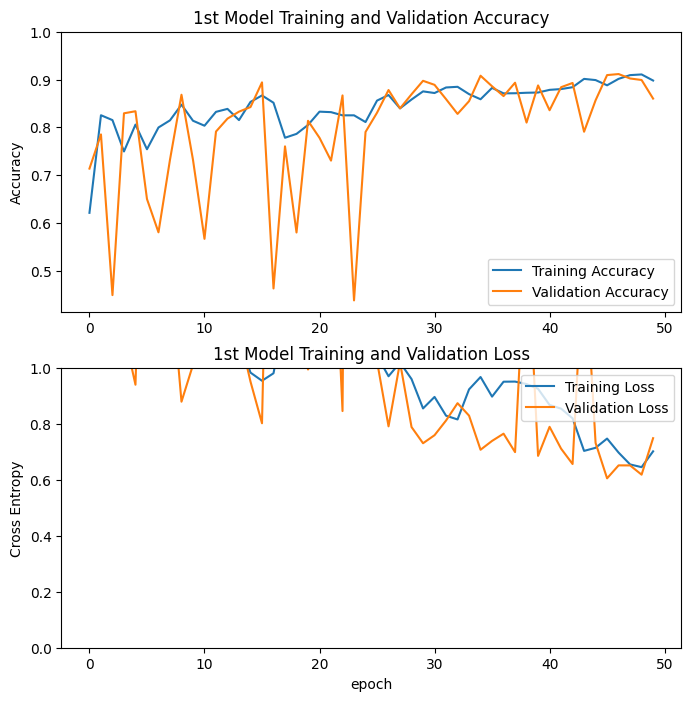

In [27]:
# Retrieve Accuracy and Loss from Segmentation Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

# Initialize Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Initialize Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Test OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:00<00:00, 297.16it/s]


In [29]:
# Evaluate Model
loss, accuracy = unet.evaluate(test)

17/17 [==============================] - 2s 138ms/step - loss: 0.5121 - accuracy: 0.8561


1/1 [==============================] - 2s 2s/step


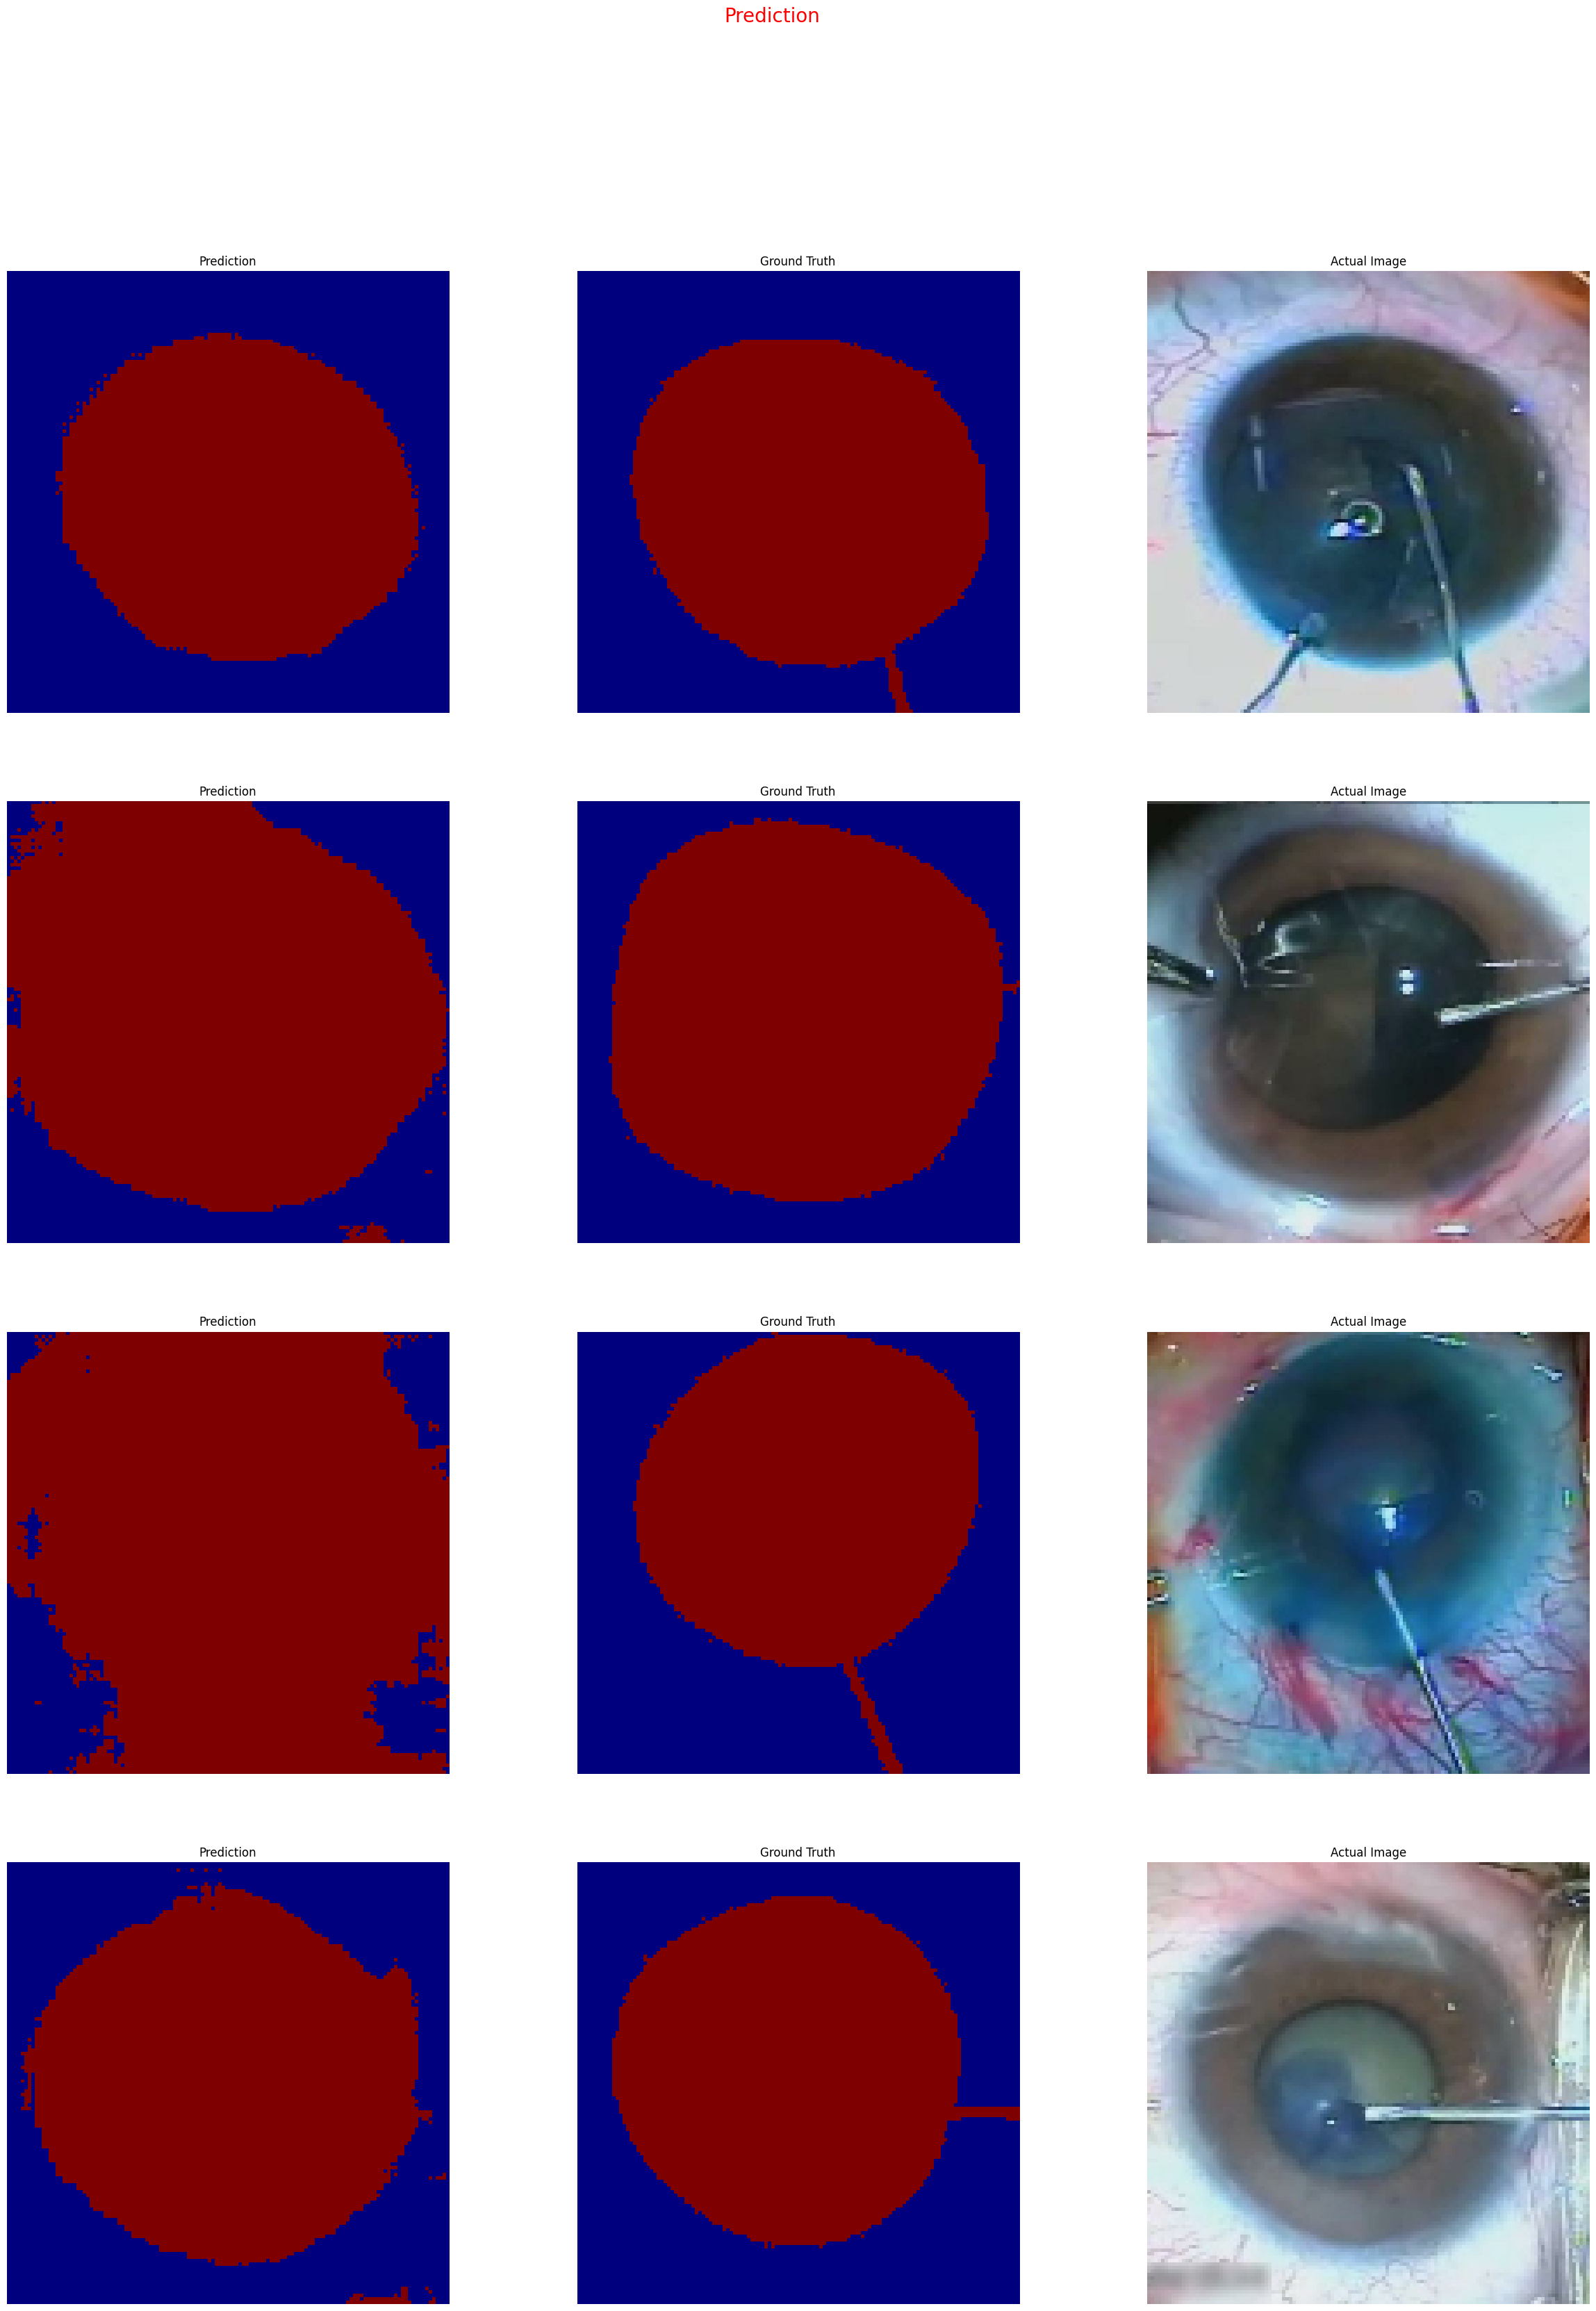

In [30]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

###

### Test With Cataract Dataset

In [31]:
# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

# Initialize Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Initialize Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Test OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_immatur.png
4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_immatur.png


100%|██████████| 4/4 [00:00<00:00, 210.00it/s]


1/1 [==============================] - 2s 2s/step


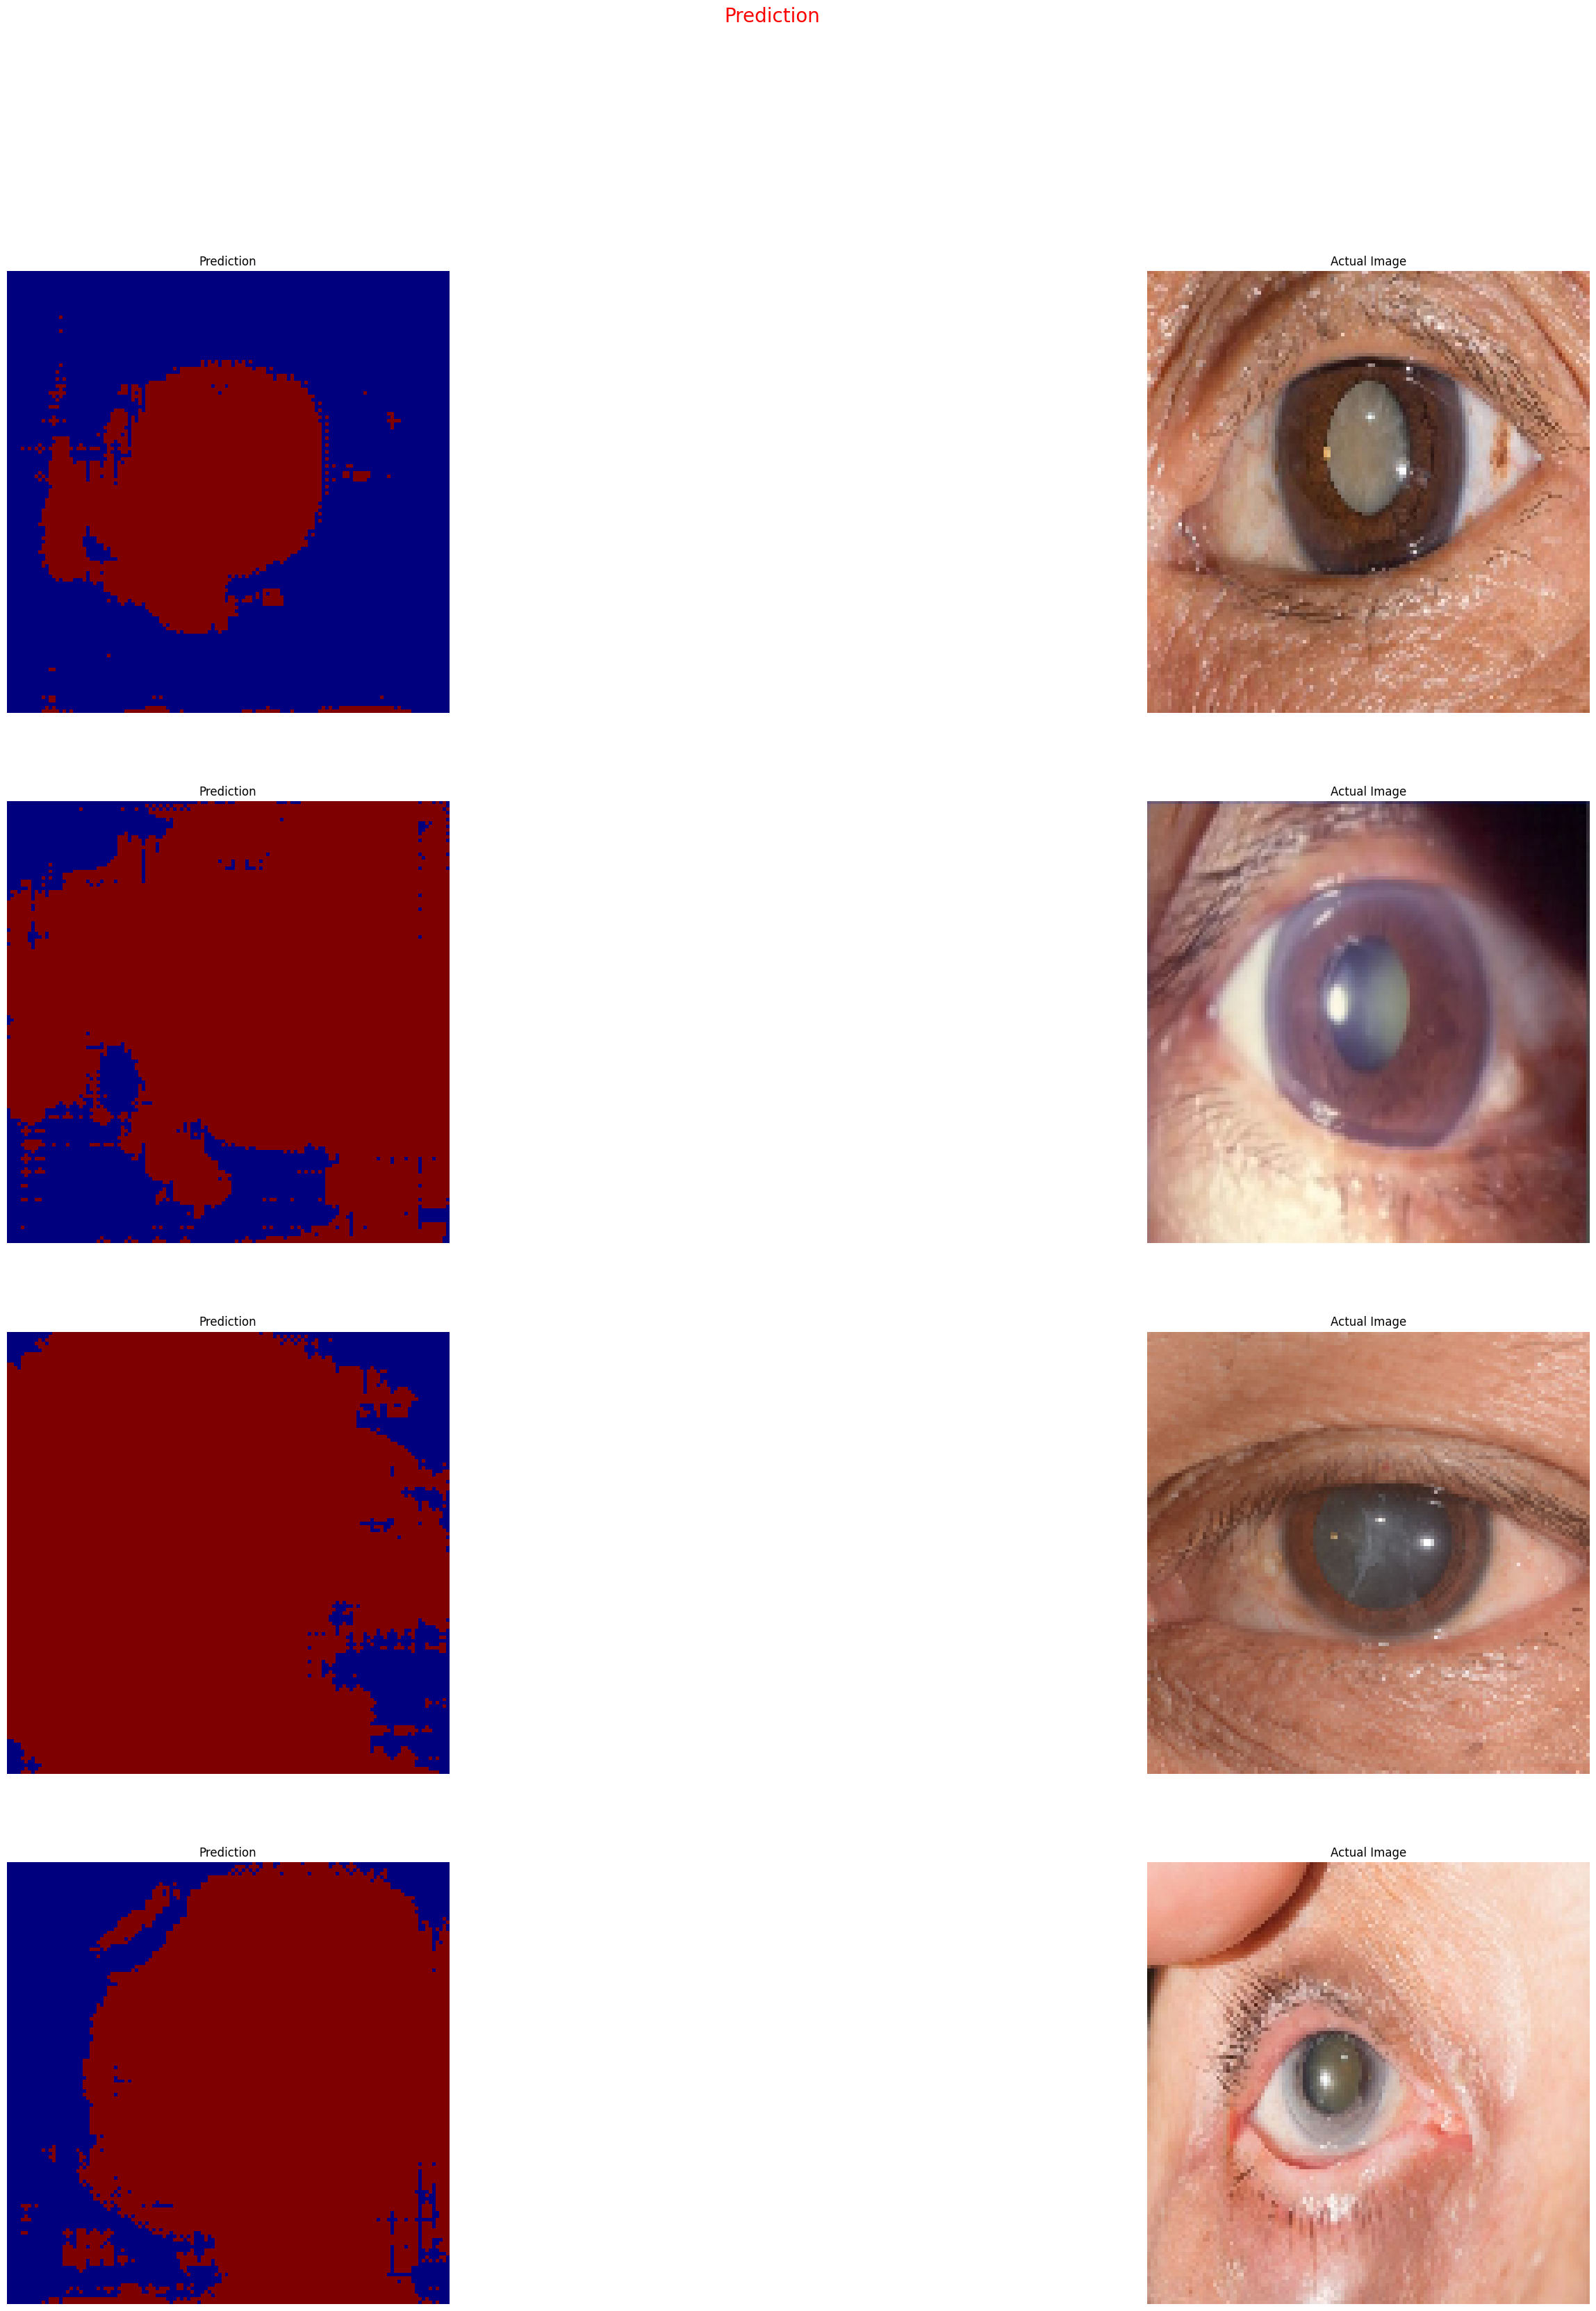

In [32]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

### Model Architecture #2 (U-Net Vanilla)

In [33]:
# Encoder Block for Contracting Path in U-Net Architecture
def EncoderBlock(input_layer, n_filter, kernel_size=(3,3), kernel_initializer='he_normal', dropout_prob=0.1, max_pooling=True):
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_layer)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if max_pooling:
        next_layer = keras.layers.MaxPooling2D((2,2))(x)
    else:
        next_layer = x

    skip_connection = x

    return next_layer, skip_connection

# Decoder Block for Expansive Path in U-Net Architecture
def DecoderBlock(input_layer, skip_layer, n_filter, kernel_size=(2,2), kernel_initializer='he_normal', dropout_prob=0.1):
    x = keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=(2,2), padding='same')(input_layer)
    x = keras.layers.concatenate([x, skip_layer])
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    next_layer = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    return next_layer

In [34]:
# Input Layer
input_layer = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")

# Build Contraction Path
c1, s1 = EncoderBlock(input_layer, 16)
c2, s2 = EncoderBlock(c1, 32)
c3, s3 = EncoderBlock(c2, 64)
c4, s4 = EncoderBlock(c3, 128)
c5, _ = EncoderBlock(c4, 256, max_pooling=False)

# Build Expansive Path
e1 = DecoderBlock(c5, s4, 128)
e2 = DecoderBlock(e1, s3, 64)
e3 = DecoderBlock(e2, s2, 32)
e4 = DecoderBlock(e3, s1, 16)

# Output Layer
output = keras.layers.Conv2D(256, (1,1), activation='sigmoid')(e4)

# Initialize Model
unet2 = keras.Model(inputs=[input_layer], outputs=[output])

In [35]:
unet2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_image[0][0]']         
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                            

### Train Model #2

In [36]:
unet2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
model_history2 = unet2.fit(
    train,
    validation_data=val,
    steps_per_epoch=(len(X_train) // BATCH_SIZE_SEG),
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    # callbacks=[stop_callback]
)

Epoch 1/50
147/147 - 19s - loss: 1.7602 - accuracy: 0.6097 - val_loss: 0.8817 - val_accuracy: 0.8868 - 19s/epoch - 129ms/step
Epoch 2/50
147/147 - 9s - loss: 0.6319 - accuracy: 0.8478 - val_loss: 0.6470 - val_accuracy: 0.8498 - 9s/epoch - 60ms/step
Epoch 3/50
147/147 - 9s - loss: 0.5986 - accuracy: 0.8547 - val_loss: 0.4158 - val_accuracy: 0.9144 - 9s/epoch - 60ms/step
Epoch 4/50
147/147 - 9s - loss: 0.5940 - accuracy: 0.8617 - val_loss: 0.4619 - val_accuracy: 0.8977 - 9s/epoch - 60ms/step
Epoch 5/50
147/147 - 9s - loss: 0.5425 - accuracy: 0.8777 - val_loss: 0.4845 - val_accuracy: 0.9102 - 9s/epoch - 60ms/step
Epoch 6/50
147/147 - 9s - loss: 0.5357 - accuracy: 0.8844 - val_loss: 0.4147 - val_accuracy: 0.9029 - 9s/epoch - 60ms/step
Epoch 7/50
147/147 - 9s - loss: 0.5365 - accuracy: 0.8861 - val_loss: 0.4358 - val_accuracy: 0.9128 - 9s/epoch - 60ms/step
Epoch 8/50
147/147 - 9s - loss: 0.5161 - accuracy: 0.8932 - val_loss: 0.3577 - val_accuracy: 0.9205 - 9s/epoch - 60ms/step
Epoch 9/50
14

### Evaluate Model With Test Dataset

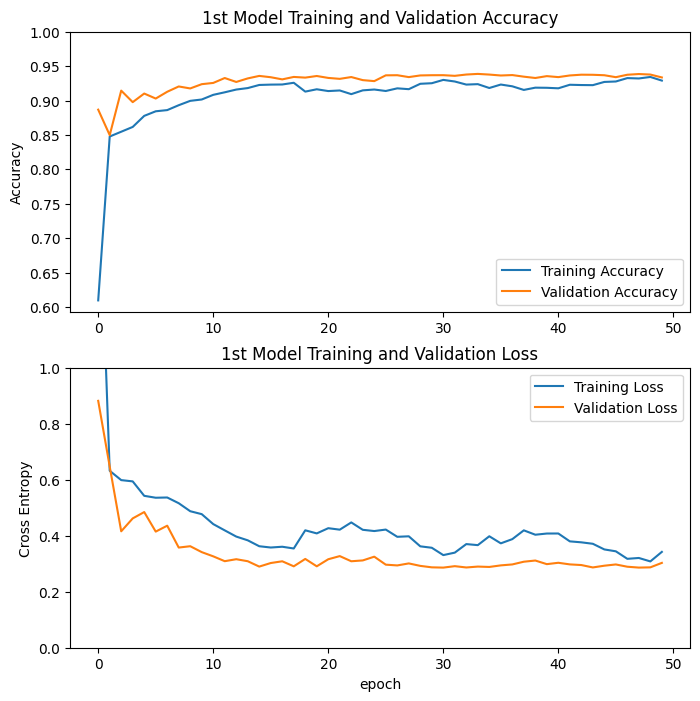

In [38]:
# Retrieve Accuracy and Loss from Segmentation Model
acc = model_history2.history['accuracy']
val_acc = model_history2.history['val_accuracy']
loss = model_history2.history['loss']
val_loss = model_history2.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

# Initialize Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Initialize Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Test OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:00<00:00, 308.20it/s]


In [40]:
# Evaluate Model
loss, accuracy = unet2.evaluate(test)

17/17 [==============================] - 1s 56ms/step - loss: 0.1720 - accuracy: 0.9508


1/1 [==============================] - 0s 315ms/step


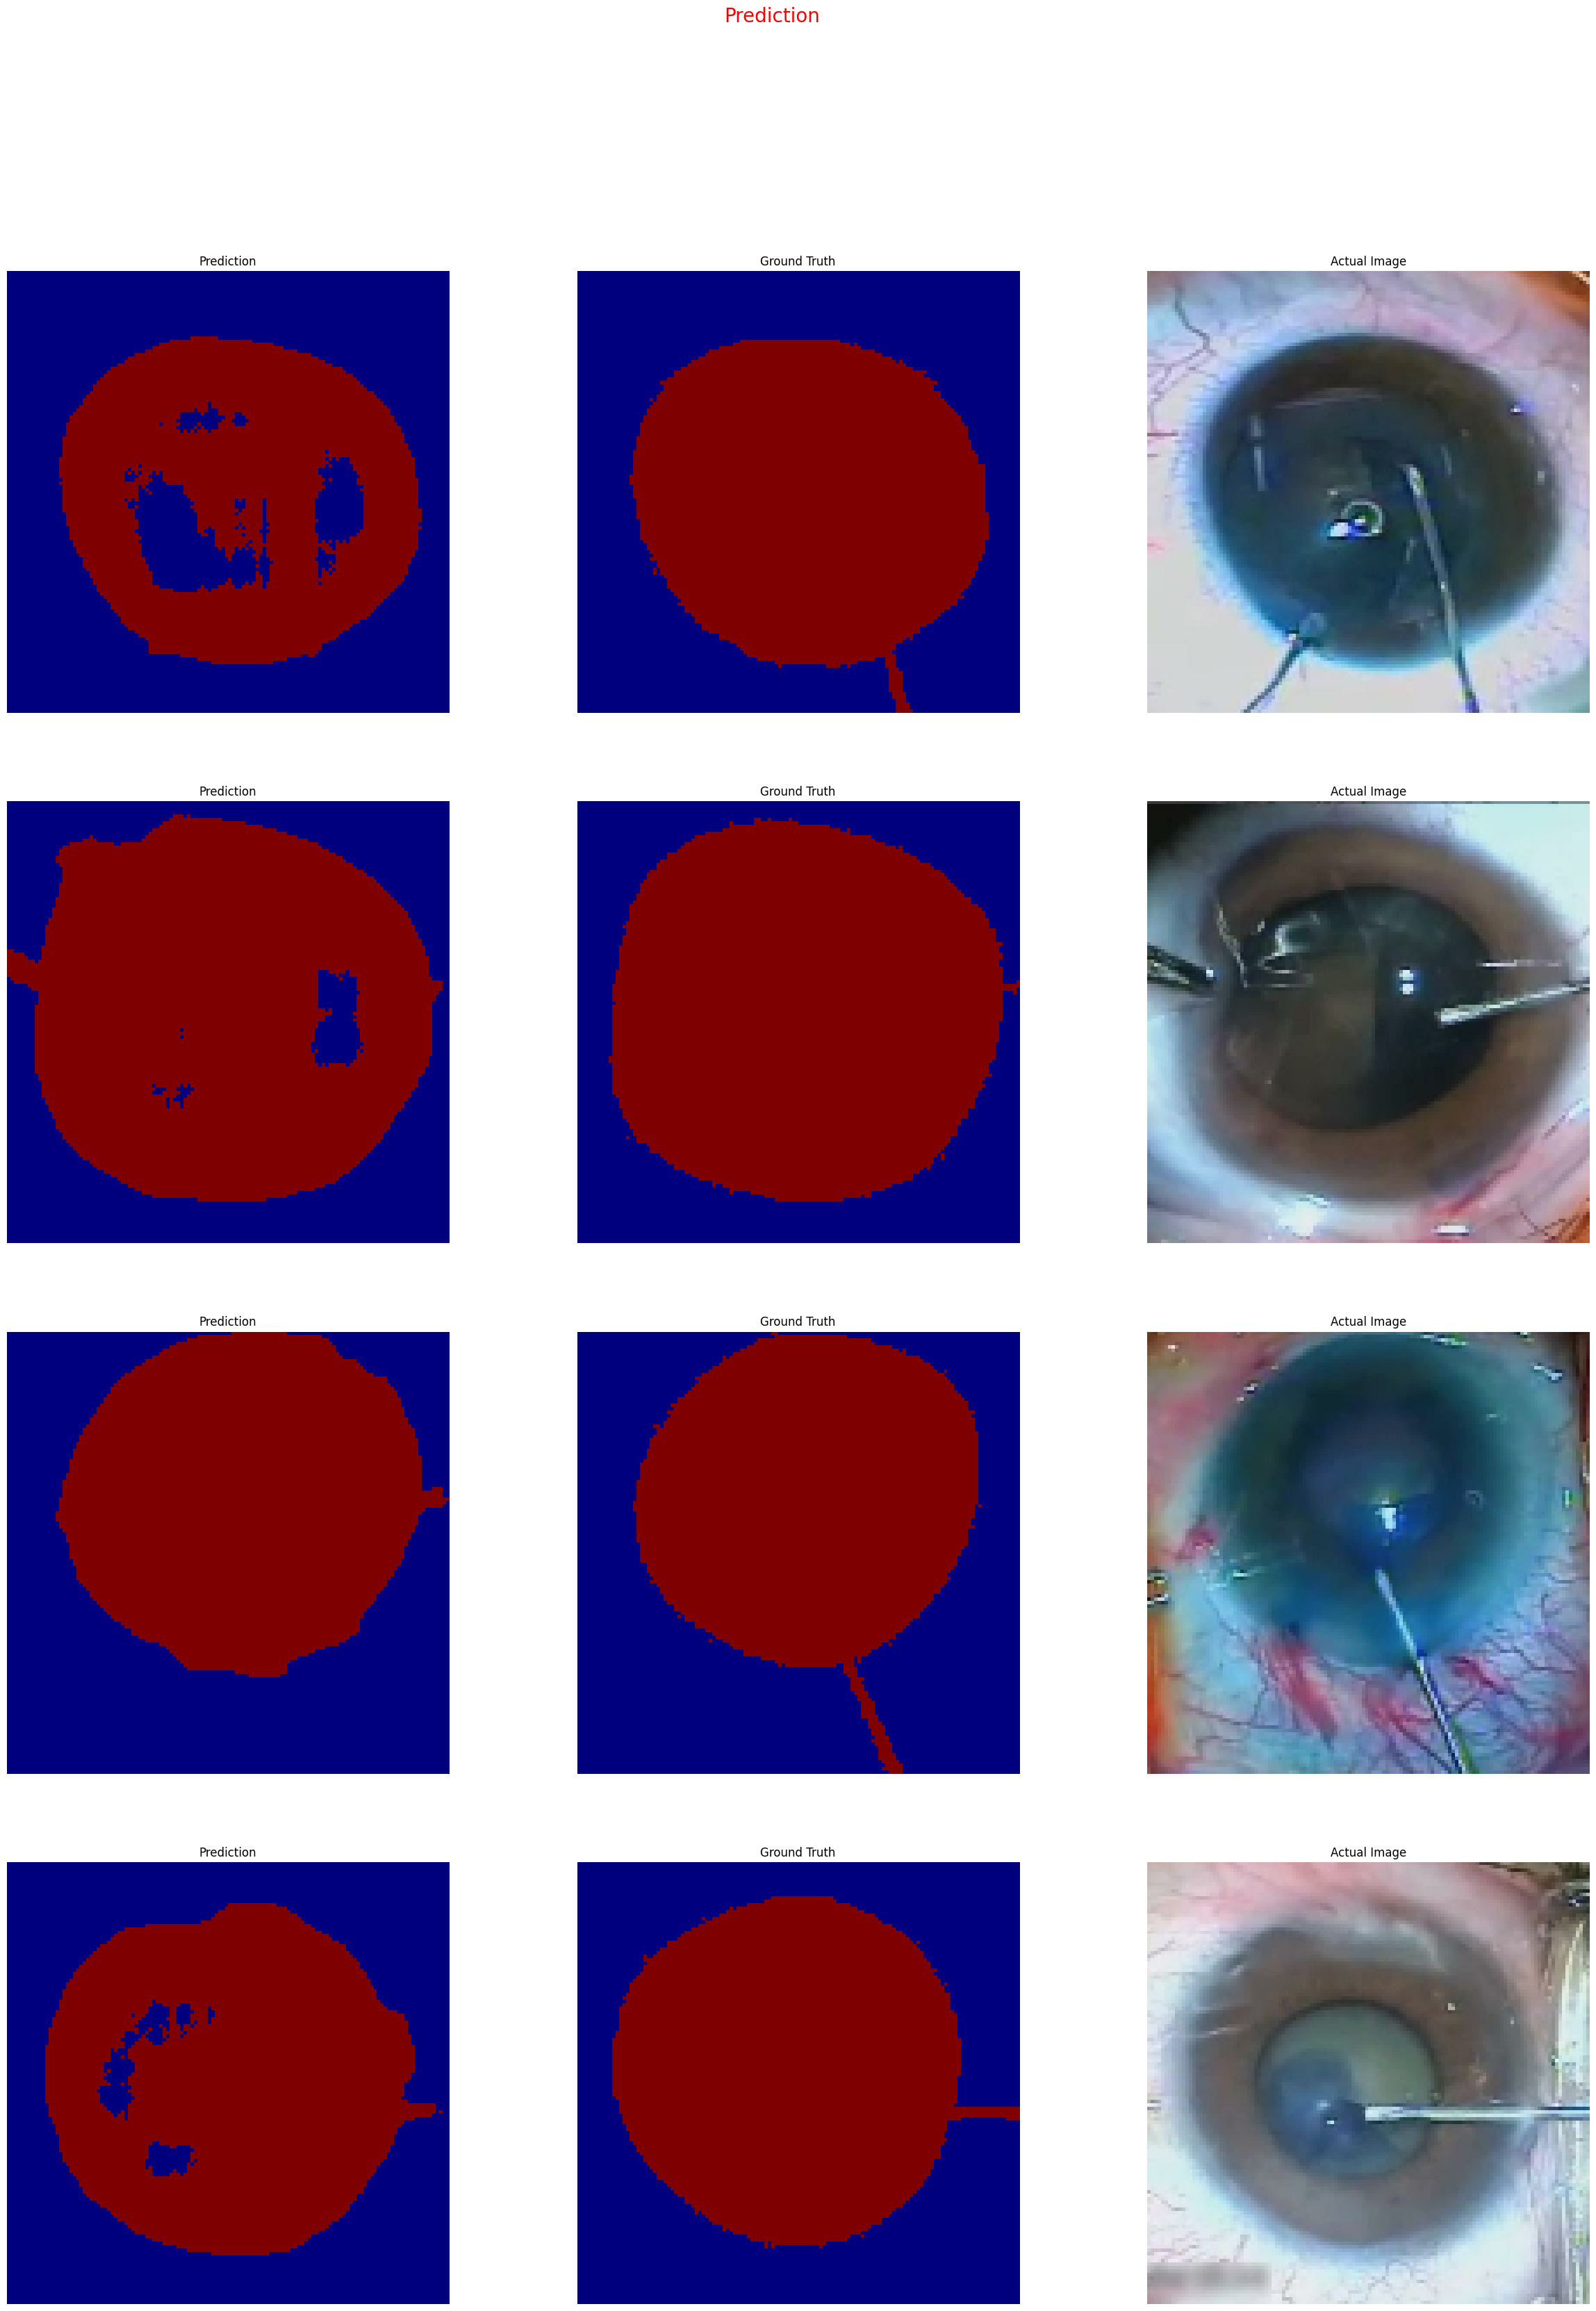

In [41]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet2.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

### Test With Cataract Dataset

In [42]:
# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

# Initialize Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Initialize Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Test OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_immatur.png
4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_immatur.png


100%|██████████| 4/4 [00:00<00:00, 210.11it/s]


1/1 [==============================] - 1s 607ms/step


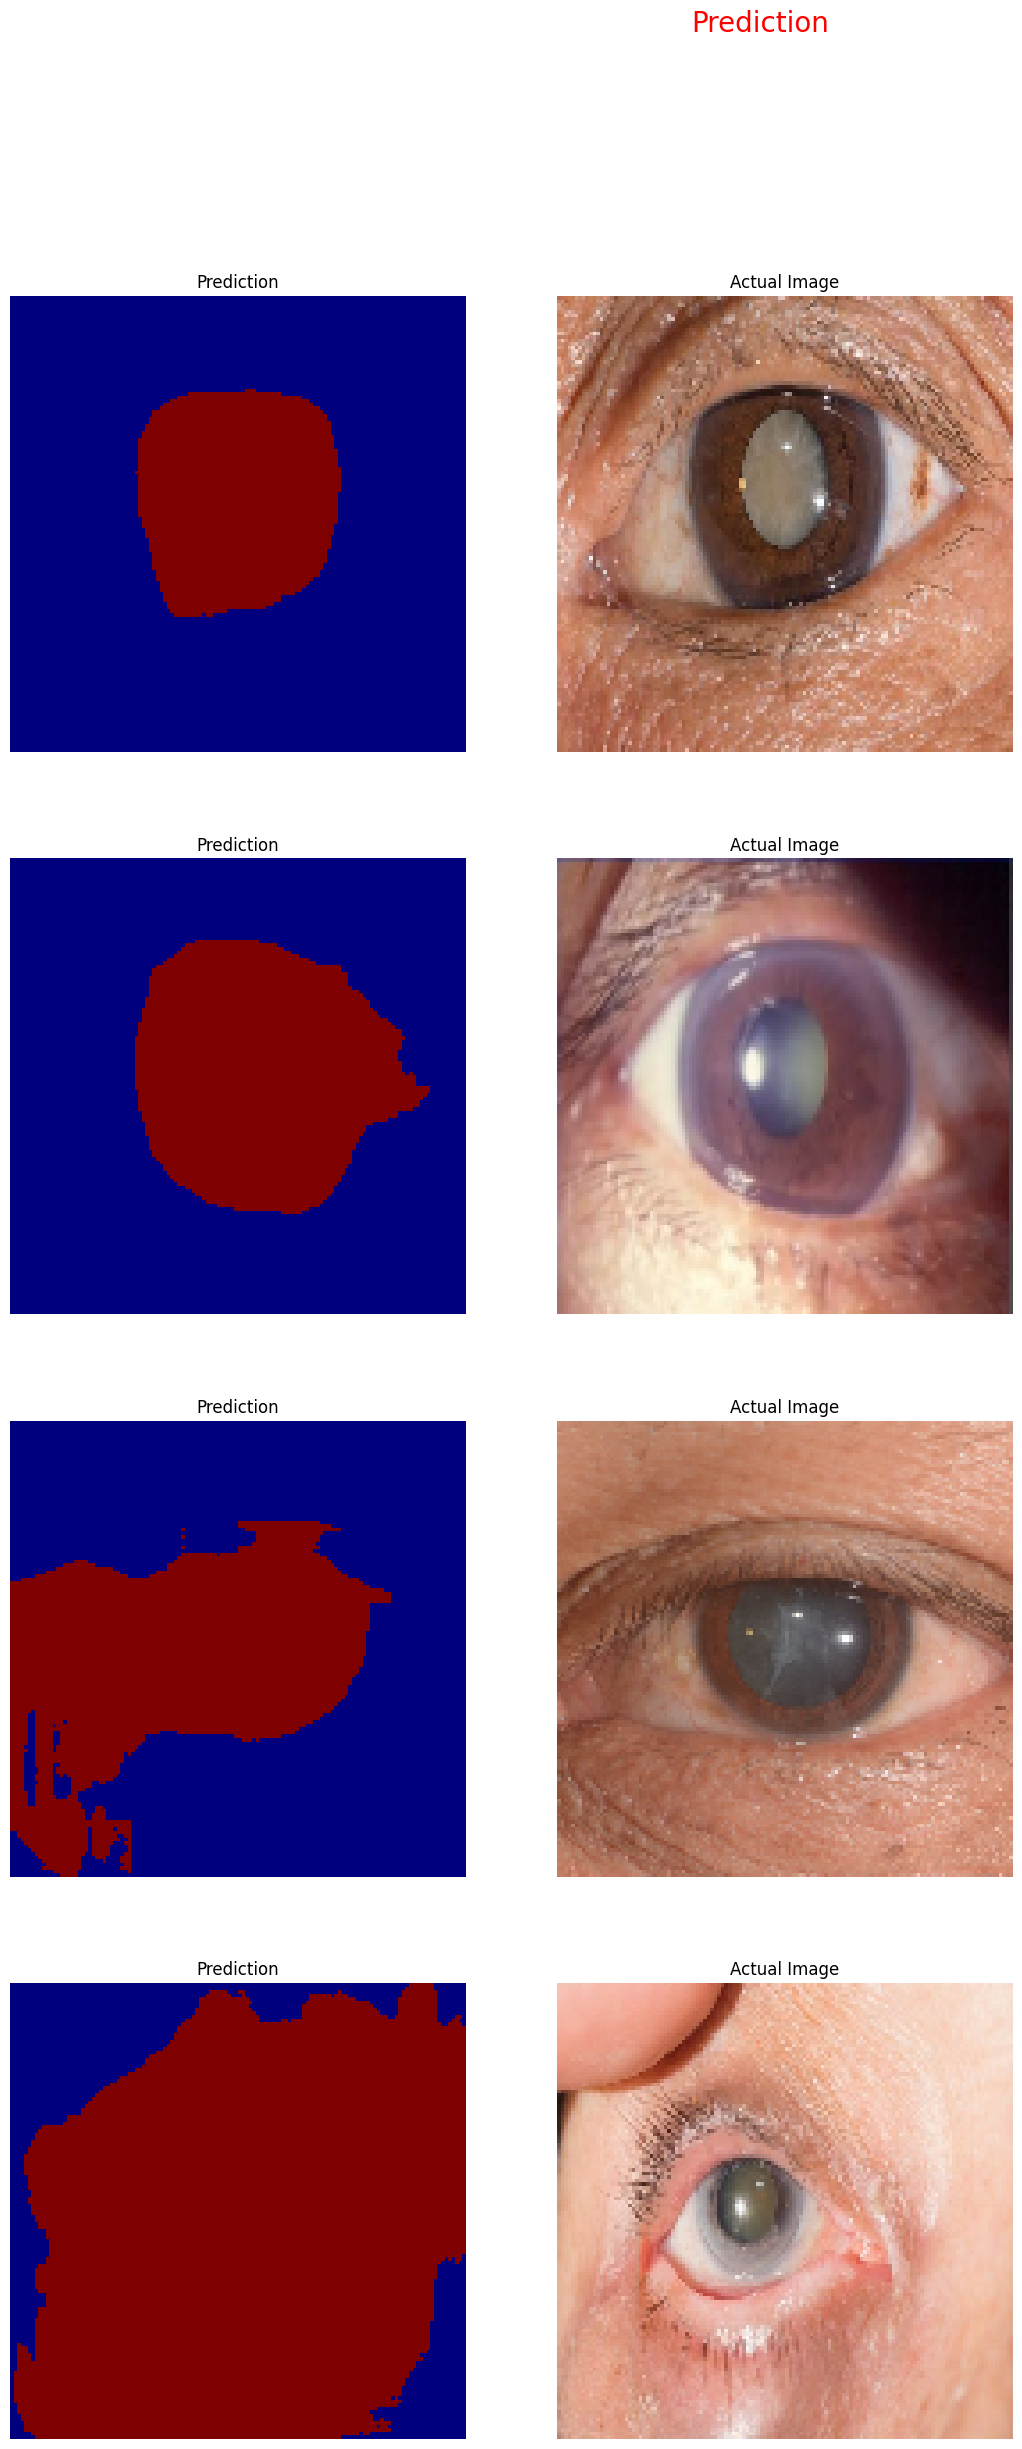

In [43]:
# Select a Cataract Test Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet2.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,2+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()